<a href="https://colab.research.google.com/github/Cutie-tee/Roboreviews_project/blob/main/Clustering_with_zero_classifcation_topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset consists of 3 files: 1429_1.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv




In [10]:

!pip install --upgrade pandas
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 99.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [12]:
import pandas as pd

def safe_read_csv(file_path):
    """
    Safely reads a CSV file by handling parsing issues.
    """
    try:
        # Read the CSV with specific options for handling errors
        return pd.read_csv(
            file_path,
            on_bad_lines='skip',  # Skips problematic lines
            quotechar='"',       # Specifies the quote character
            escapechar='\\',     # Escapes special characters
            engine='python'      # Use Python engine for better handling of malformed rows
        )
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return None

# Load datasets safely
file1_data = safe_read_csv('1429_1.csv')
file2_data = safe_read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
file3_data = safe_read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Check if all files loaded successfully
if file1_data is not None and file2_data is not None and file3_data is not None:
    # Standardizing column names
    file1_data.rename(columns=lambda x: x.strip(), inplace=True)
    file2_data.rename(columns=lambda x: x.strip(), inplace=True)
    file3_data.rename(columns=lambda x: x.strip(), inplace=True)

    # Align datasets to common columns
    common_columns = list(set(file1_data.columns) & set(file2_data.columns) & set(file3_data.columns))

    # Selecting only common columns
    file1_data = file1_data[common_columns]
    file2_data = file2_data[common_columns]
    file3_data = file3_data[common_columns]

    # Concatenate datasets
    combined_data = pd.concat([file1_data, file2_data, file3_data], ignore_index=True)

    # Dropping duplicates
    combined_data.drop_duplicates(inplace=True)

    # Resetting index
    combined_data.reset_index(drop=True, inplace=True)

    # Save cleaned dataset
    combined_data.to_csv('combined_reviews_cleaned.csv', index=False)

    # Display overview
    print("Dataset successfully cleaned and saved.")
    print(combined_data.info())
else:
    print("One or more files could not be loaded.")

Dataset successfully cleaned and saved.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28980 entries, 0 to 28979
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28980 non-null  object 
 1   reviews.username     28974 non-null  object 
 2   reviews.title        28968 non-null  object 
 3   manufacturer         28980 non-null  object 
 4   reviews.numHelpful   20778 non-null  float64
 5   reviews.sourceURLs   28980 non-null  object 
 6   reviews.date         28967 non-null  object 
 7   reviews.doRecommend  20764 non-null  object 
 8   asins                28978 non-null  object 
 9   brand                28980 non-null  object 
 10  keys                 28980 non-null  object 
 11  reviews.id           28 non-null     float64
 12  categories           28980 non-null  object 
 13  name                 28980 non-null  object 
 14  reviews.rating       28952 non-null  float64
 

In [13]:

# Load the combined dataset
import pandas as pd

# Load the cleaned dataset
combined_data = pd.read_csv('combined_reviews_cleaned.csv')

# Display initial missing values
print("Missing Values Before Processing:")
print(combined_data.isnull().sum())

# 1. Drop rows with missing `reviews.text` (essential for all tasks)
combined_data = combined_data.dropna(subset=['reviews.text'])

# 2. Drop rows with missing `reviews.rating` (essential for classification and clustering)
combined_data = combined_data.dropna(subset=['reviews.rating'])

# 3. Optional: Handle missing values in other columns (example: reviews.doRecommend)
# Here, replace missing values with a default or mode value
combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].fillna('Unknown')

# 4. Drop columns with minimal or irrelevant data (e.g., `reviews.id` with only 71 non-null values)
columns_to_drop = ['reviews.id']
combined_data = combined_data.drop(columns=columns_to_drop, errors='ignore')

# Display missing values after processing
print("\nMissing Values After Processing:")
print(combined_data.isnull().sum())

# Save the preprocessed dataset
preprocessed_dataset_path = 'preprocessed_reviews.csv'
combined_data.to_csv(preprocessed_dataset_path, index=False)

print(f"Preprocessed dataset saved to {preprocessed_dataset_path}.")


Missing Values Before Processing:
id                         0
reviews.username           6
reviews.title             12
manufacturer               0
reviews.numHelpful      8202
reviews.sourceURLs         0
reviews.date              13
reviews.doRecommend     8216
asins                      2
brand                      0
keys                       0
reviews.id             28952
categories                 0
name                       0
reviews.rating            28
reviews.text               1
reviews.dateSeen           0
dtype: int64

Missing Values After Processing:
id                        0
reviews.username          6
reviews.title            12
manufacturer              0
reviews.numHelpful     8173
reviews.sourceURLs        0
reviews.date              4
reviews.doRecommend       0
asins                     2
brand                     0
keys                      0
categories                0
name                      0
reviews.rating            0
reviews.text              0
review

In [14]:
combined_data['reviews.username'] = combined_data['reviews.username'].fillna("Anonymous")
combined_data['name'] = combined_data['name'].fillna("Unknown")

combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].map({'Yes': True, 'No': False})

assert combined_data['reviews.rating'].between(1, 5).all()

combined_data.to_csv('final_preprocessed_reviews.csv', index=False)
print("Final preprocessed dataset saved.")



Final preprocessed dataset saved.


In [15]:

import pandas as pd

# Load the dataset
data = pd.read_csv('final_preprocessed_reviews.csv', low_memory=False)

# Get the number of rows
num_rows = data.shape[0]

print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset: 28951


**Sentinent analysis  with RoBerta-base**

**Clustering based on emrging trends to ascertain partner growth opportuntities** . Lifestyle Enhancers:

Products designed to improve daily routines or convenience.
Includes items like Nespresso pods, smart assistants, pet carriers, and other gadgets that simplify life.
Creative and Productivity Tools:

Products for work, study, or creative activities.
Includes laptops, tablets, keyboards, laptop stands, webcams, and styluses.
Health and Wellness:

Devices that focus on personal health, fitness, or beauty.
Includes fitness trackers, electric massagers, hairdryers, and grooming devices.
Entertainment and Immersion:

Products that provide entertainment or enhanced experiences.
Includes gaming consoles, headphones, speakers, VR headsets, and streaming devices.
Power and Connectivity Solutions:

Products that enable devices to stay powered or connected.
Includes chargers, batteries, power banks, docking stations, and USB hubs.
Eco-Friendly and Sustainable Solutions:

Products marketed as sustainable or environmentally friendly.

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from datasets import Dataset
import torch

# Disable Weights & Biases (W&B) logging
import os
os.environ["WANDB_DISABLED"] = "true"

# Load the final_preprocessed dataset
data = pd.read_csv('final_preprocessed_reviews.csv', low_memory=False)

# Map ratings to sentiment using the given labels
def map_rating_to_sentiment(rating):
    if rating > 3:
        return 2  # Positive
    elif rating == 3:
        return 1  # Neutral
    else:
        return 0  # Negative

data['sentiment'] = data['reviews.rating'].apply(map_rating_to_sentiment)

# Handle class imbalance with oversampling
positive_data = data[data['sentiment'] == 2]
neutral_data = data[data['sentiment'] == 1]
negative_data = data[data['sentiment'] == 0]

# Oversample minority classes to match the Positive class size
neutral_oversampled = resample(neutral_data, replace=True, n_samples=len(positive_data), random_state=42)
negative_oversampled = resample(negative_data, replace=True, n_samples=len(positive_data), random_state=42)

# Combine back into one dataset
balanced_data = pd.concat([positive_data, neutral_oversampled, negative_oversampled])

# Split the balanced data into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    balanced_data['reviews.text'], balanced_data['sentiment'], test_size=0.2, random_state=42
)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer and model setup
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes

# Tokenize datasets
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Compute class weights for weighted loss
class_weights = torch.tensor(
    [1.0 / len(negative_data), 1.0 / len(neutral_data), 1.0 / len(positive_data)], dtype=torch.float
).to("cuda" if torch.cuda.is_available() else "cpu")

# Modify the model's loss function to include class weights
from torch.nn import CrossEntropyLoss
model.config.problem_type = "single_label_classification"
model.classifier.weight = class_weights

# Training arguments with epoch-based evaluation, early stopping, and adjusted learning rate
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Evaluate once per epoch
    save_strategy="epoch",        # Save model once per epoch
    learning_rate=1e-5,           # Lower learning rate for better convergence
    per_device_train_batch_size=8,
    num_train_epochs=10,          # Set high epochs; early stopping will stop training earlier
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    report_to="none",             # Disable W&B and other integrations
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="eval_loss",  # Monitor validation loss
    greater_is_better=False       # Smaller loss is better
)

# Define evaluation metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Define Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Stop if no improvement for 2 evaluations
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("./fine_tuned_roberta_sentiment")
tokenizer.save_pretrained("./fine_tuned_roberta_sentiment")

print("Model fine-tuned and saved successfully!")




tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/63180 [00:00<?, ? examples/s]

Map:   0%|          | 0/15795 [00:00<?, ? examples/s]

<ipython-input-16-275cee15637f>:107: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299300,0.164255,0.967205,0.969760,0.966871,0.967254
2,0.160100,0.062750,0.986958,0.987244,0.986829,0.986923
3,0.117200,0.099411,0.984932,0.985519,0.984722,0.984837


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.299300,0.164255,0.967205,0.969760,0.966871,0.967254
2,0.160100,0.062750,0.986958,0.987244,0.986829,0.986923
3,0.117200,0.099411,0.984932,0.985519,0.984722,0.984837
4,0.003700,0.075803,0.988351,0.988665,0.988196,0.988283


Model fine-tuned and saved successfully!


Enhacing with using topics and categorization

In [17]:
# Import necessary libraries
from transformers import pipeline
import pandas as pd
import torch
from datasets import Dataset
from tqdm.notebook import tqdm

# Check GPU availability
print("Checking if we have a GPU...")
if torch.cuda.is_available():
    print("Yes! Found GPU!")
    BATCH_SIZE = 8
else:
    print("No GPU found - will be slower")
    BATCH_SIZE = 4

# Set up AI classifier
print("Setting up the AI...")
classifier = pipeline(
    "zero-shot-classification",
    model="cross-encoder/nli-deberta-v3-large",
    device=0 if torch.cuda.is_available() else -1
)

# Product clusters for reviews
categories = [
    "Daily Convenience",
    "Creative and Productivity Tools",
    "Health and Wellness",
    "Entertainment and Immersion",
    "Power and Connectivity Solutions",
    "Eco-Friendly and Sustainable Solutions"
]

# Function to classify reviews
def classify_text(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )

        # Get the top category for each review
        return {
            "category": [output["labels"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {"category": ["Error"] * len(examples["reviews.text"])}

# Process data in chunks (since DeBERTa uses more memory)
print("\nStarting to process reviews...")
chunk_size = 5000  # Process 5000 reviews at a time

for i, chunk_df in enumerate(pd.read_csv('final_preprocessed_reviews.csv', chunksize=chunk_size)):
    print(f"\nProcessing chunk {i+1}")

    # Convert chunk to dataset
    chunk_dataset = Dataset.from_pandas(chunk_df)

    # Process chunk
    classified_chunk = chunk_dataset.map(
        classify_text,
        batched=True,
        batch_size=BATCH_SIZE,
        remove_columns=chunk_dataset.column_names,
        desc=f"Classifying chunk {i+1}"
    )

    # Convert results back to DataFrame
    chunk_results = pd.DataFrame({
        'name': chunk_df['name'],  # Include the 'name' column
        'reviews.text': chunk_df['reviews.text'],
        'category': classified_chunk['category']
    })

    # Save results (append after first chunk)
    chunk_results.to_csv('new_classified_reviews.csv',
                         mode='a' if i > 0 else 'w',
                         header=i == 0,
                         index=False)

    print(f"Finished chunk {i+1}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nAll done! Check 'new_classified_reviews.csv' for results")

# Show some examples
print("\nHere are some example results:")
try:
    examples = pd.read_csv('new_classified_reviews.csv', nrows=3)
    for i, row in examples.iterrows():
        print(f"\nProduct: {row['name']}")
        print(f"Review {i+1}:")
        print(f"Text: {row['reviews.text'][:100]}...")  # First 100 characters
        print(f"Category: {row['category']}")
except Exception as e:
    print(f"Couldn't read the results file: {e}")



Checking if we have a GPU...
Yes! Found GPU!
Setting up the AI...


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(



Starting to process reviews...

Processing chunk 1


Classifying chunk 1:   0%|          | 0/5000 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Finished chunk 1

Processing chunk 2


Classifying chunk 2:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 2

Processing chunk 3


Classifying chunk 3:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 3

Processing chunk 4


Classifying chunk 4:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 4

Processing chunk 5


Classifying chunk 5:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 5

Processing chunk 6


Classifying chunk 6:   0%|          | 0/3951 [00:00<?, ? examples/s]

Finished chunk 6

All done! Check 'new_classified_reviews.csv' for results

Here are some example results:

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 1:
Text: This product so far has not disappointed. My children love to use it and I like the ability to monit...
Category: Creative and Productivity Tools

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 2:
Text: great for beginner or experienced person. Bought as a gift and she loves it...
Category: Entertainment and Immersion

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 3:
Text: Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, lear...
Category: Entertainment and Immersion


Adding Topic Modelling to align with actual content of thr reviews

In [18]:
#Add confidence scores to the output for better evaluation of classifications.
def classify_text_with_confidence(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )
        return {
            "category": [output["labels"][0] for output in outputs],
            "confidence": [output["scores"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {
            "category": ["Error"] * len(examples["reviews.text"]),
            "confidence": [0] * len(examples["reviews.text"])
        }


In [19]:
classified_chunk = chunk_dataset.map(
    classify_text_with_confidence,
    batched=True,
    batch_size=BATCH_SIZE,
    remove_columns=[],  # Avoid removing any columns to retain "confidence"
    desc=f"Classifying chunk {i+1}"
)


Classifying chunk 3:   0%|          | 0/3951 [00:00<?, ? examples/s]

In [21]:
#Confidence is Saved when converting the chunk results back to a DataFrame:
chunk_results = pd.DataFrame({
    'name': chunk_df['name'],  # Include product name
    'reviews.text': chunk_df['reviews.text'],  # Include review text
    'category': classified_chunk['category'],  # Include assigned category
    'confidence': classified_chunk['confidence'],  # Include confidence scores
})


In [22]:
print(chunk_results.head())


                                                    name  \
25000  AmazonBasics AAA Performance Alkaline Batterie...   
25001  AmazonBasics AAA Performance Alkaline Batterie...   
25002  AmazonBasics AAA Performance Alkaline Batterie...   
25003  AmazonBasics AAA Performance Alkaline Batterie...   
25004  AmazonBasics AAA Performance Alkaline Batterie...   

                                          reviews.text  \
25000                                     Works great.   
25001                                     Works great.   
25002                        Works great. Great price.   
25003  Works great. Last as long as other brand names.   
25004                           Works great/best price   

                                     category  confidence  
25000  Eco-Friendly and Sustainable Solutions    0.336370  
25001  Eco-Friendly and Sustainable Solutions    0.336370  
25002         Creative and Productivity Tools    0.300063  
25003         Creative and Productivity Tools    0

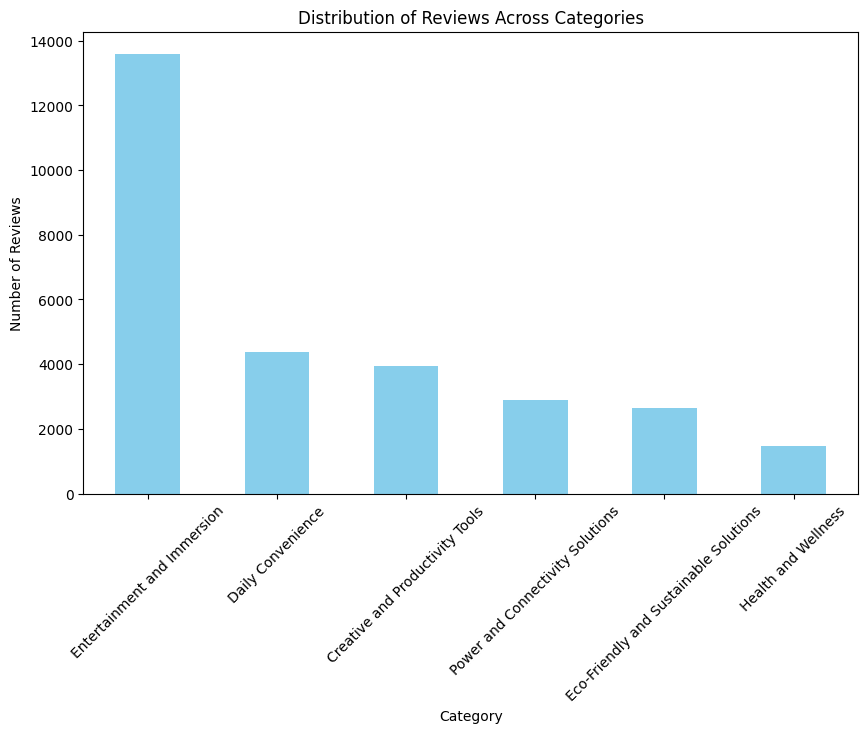

In [23]:
import matplotlib.pyplot as plt

# Load the results
results = pd.read_csv('new_classified_reviews.csv')

# Plot category distribution
category_counts = results['category'].value_counts()
category_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Reviews Across Categories')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


In [24]:

results = chunk_results
low_confidence_reviews = results[results['confidence'] < 0.5] # Now 'results' has the 'confidence' column
print("Low-confidence reviews:")
print(low_confidence_reviews[['reviews.text', 'category', 'confidence']].head())


Low-confidence reviews:
                                          reviews.text  \
25000                                     Works great.   
25001                                     Works great.   
25002                        Works great. Great price.   
25003  Works great. Last as long as other brand names.   
25004                           Works great/best price   

                                     category  confidence  
25000  Eco-Friendly and Sustainable Solutions    0.336370  
25001  Eco-Friendly and Sustainable Solutions    0.336370  
25002         Creative and Productivity Tools    0.300063  
25003         Creative and Productivity Tools    0.258615  
25004         Creative and Productivity Tools    0.299779  


In [25]:
# Filter reviews for "Entertainment and Immersion"
entertainment_reviews = results[results['category'] == 'Entertainment and Immersion']
print("Sample Entertainment Reviews:")
print(entertainment_reviews['reviews.text'].head(10))


Sample Entertainment Reviews:
25031                                             Worth it
25033                                      Worth the price
25034                                                  wow
25050                                                  zap
25051    Used in flash lights they lasted 4 days before...
25057    When using these batteries in a professional c...
25060    Found these here before Christmas, and decided...
25064                    All my remotes have new batteries
25090                   Can't go wrong at 21 cents appease
25101                       didn't seem to last very long.
Name: reviews.text, dtype: object


In [26]:
# Filter short or generic reviews in "Entertainment and Immersion"
short_reviews = entertainment_reviews[entertainment_reviews['reviews.text'].str.len() < 20]
print("Short Reviews in 'Entertainment and Immersion':")
print(short_reviews[['reviews.text', 'category']].head(10))


Short Reviews in 'Entertainment and Immersion':
              reviews.text                     category
25031             Worth it  Entertainment and Immersion
25033      Worth the price  Entertainment and Immersion
25034                  wow  Entertainment and Immersion
25050                  zap  Entertainment and Immersion
25166   good for the price  Entertainment and Immersion
25200           Good value  Entertainment and Immersion
25201           Good value  Entertainment and Immersion
25209          Good value!  Entertainment and Immersion
25214                Great  Entertainment and Immersion
25226  great for the price  Entertainment and Immersion


In [27]:
# Filter out low-confidence reviews
filtered_results = results[results['confidence'] >= 0.5]

# Save the filtered results
filtered_results.to_csv('filtered_classified_reviews.csv', index=False)

# Check distribution after filtering
print("Distribution of reviews after filtering:")
print(filtered_results['category'].value_counts())


Distribution of reviews after filtering:
category
Daily Convenience                         167
Power and Connectivity Solutions          138
Health and Wellness                        73
Entertainment and Immersion                57
Eco-Friendly and Sustainable Solutions     43
Creative and Productivity Tools            28
Name: count, dtype: int64


In [28]:
# Load filtered-out reviews
filtered_out_reviews = results[results['confidence'] < 0.5]

# Sample 10 filtered-out reviews for manual inspection
print("Sample of filtered-out reviews:")
print(filtered_out_reviews[['reviews.text', 'confidence']].sample(10))


Sample of filtered-out reviews:
                                            reviews.text  confidence
25507  Found no difference from brand name batteries....    0.365191
25055  I've stopped buying regular batteries (AA, AAA...    0.308230
25917                     Batteries. What else can i say    0.376161
26811                                        Great value    0.269312
26657  A fair sized collection of AAA batteries that ...    0.300250
27218                             Works like a charm-m-m    0.305297
25256  Gurfr ner onggrevrf ng gur evtug cevprf. Gung'...    0.287397
25338                              Pretty good batteries    0.370226
25873                  Seem to perform well. Good price!    0.238719
25935  Great value! They last just as long as any bat...    0.337847


In [29]:
# Enrich input text with product names for better context
results['input_text'] = results['reviews.text'] + " Product: " + results['name']

# Re-run classification using enriched input with the 6 categories
outputs = classifier(
    results['input_text'].tolist(),
    candidate_labels=[
        "Daily Convenience",
        "Creative and Productivity Tools",
        "Health and Wellness",
        "Entertainment and Immersion",
        "Power and Connectivity Solutions",
        "Eco-Friendly and Sustainable Solutions"
    ],
    batch_size=BATCH_SIZE
)

# Update results with new categories and confidence scores
results['category'] = [output['labels'][0] for output in outputs]
results['confidence'] = [output['scores'][0] for output in outputs]

# Save the updated results
results.to_csv('reprocessed_6_categories_reviews.csv', index=False)

# Check updated distribution
print("Updated category distribution:")
print(results['category'].value_counts())



Updated category distribution:
category
Power and Connectivity Solutions          2481
Daily Convenience                          652
Eco-Friendly and Sustainable Solutions     491
Entertainment and Immersion                205
Creative and Productivity Tools             83
Health and Wellness                         39
Name: count, dtype: int64


In [30]:
# Assign "Unclassified" for reviews with confidence below 0.4
results['final_category'] = results.apply(
    lambda row: row['category'] if row['confidence'] >= 0.4 else 'Unclassified',
    axis=1
)

# Save results with fallback category
results.to_csv('final_6_categories_reviews.csv', index=False)

# Check distribution including fallback
print("Final category distribution:")
print(results['final_category'].value_counts())


Final category distribution:
final_category
Unclassified                              2236
Power and Connectivity Solutions          1362
Daily Convenience                          214
Eco-Friendly and Sustainable Solutions      77
Entertainment and Immersion                 31
Creative and Productivity Tools             20
Health and Wellness                         11
Name: count, dtype: int64


In [31]:
# Define keyword-based rules for ambiguous cases
rules = {
    "Power and Connectivity Solutions": ["battery", "charger", "cable", "plug"],
    "Entertainment and Immersion": ["game", "movie", "stream", "screen", "music"],
    "Health and Wellness": ["vitamin", "exercise", "nutrition", "wellness", "yoga"],
    "Daily Convenience": ["kitchen", "home", "daily", "clean", "cook"],
    "Creative and Productivity Tools": ["office", "tool", "work", "project", "creative"],
    "Eco-Friendly and Sustainable Solutions": ["eco", "sustainable", "green", "environment"]
}

# Apply rules for low-confidence reviews
def assign_category_based_on_rules(text):
    for category, keywords in rules.items():
        if any(keyword in text.lower() for keyword in keywords):
            return category
    return "Unclassified"

# Apply rules to low-confidence reviews
results['final_category'] = results.apply(
    lambda row: assign_category_based_on_rules(row['reviews.text'])
    if row['confidence'] < 0.4 else row['category'],
    axis=1
)

# Save final results
results.to_csv('rule_based_6_categories_reviews.csv', index=False)

# Check final distribution
print("Category distribution after applying rules:")
print(results['final_category'].value_counts())



Category distribution after applying rules:
final_category
Power and Connectivity Solutions          1727
Unclassified                              1302
Creative and Productivity Tools            455
Daily Convenience                          237
Eco-Friendly and Sustainable Solutions     158
Entertainment and Immersion                 60
Health and Wellness                         12
Name: count, dtype: int64


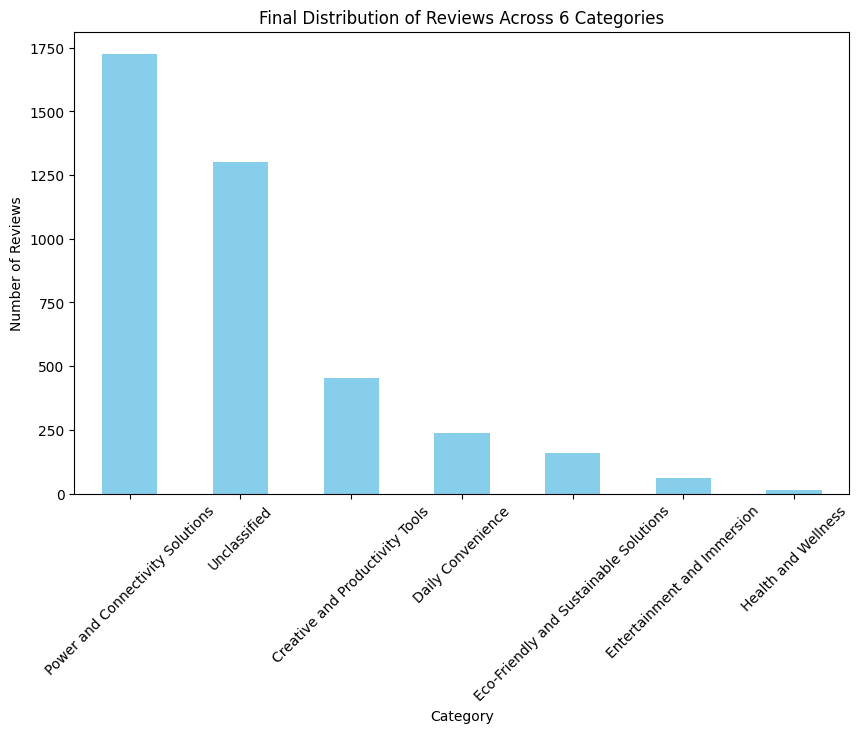

In [32]:
# Plot final distribution of categories
import matplotlib.pyplot as plt

results['final_category'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Final Distribution of Reviews Across 6 Categories')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


In [33]:
# Inspect low-confidence reviews assigned by rules
low_confidence_reviews = results[results['confidence'] < 0.4]
print("Low-confidence reviews reassigned by rules:")
print(low_confidence_reviews[['reviews.text', 'final_category']].head())


Low-confidence reviews reassigned by rules:
                                            reviews.text  \
25005    Works just as good as the name brand batteries.   
25007  Works just as well as Duracell - just half the...   
25009  Works just as well as other batteries and for ...   
25011                       Works like a regular battery   
25016  works perfectly... not much else to say. they ...   

                         final_category  
25005   Creative and Productivity Tools  
25007   Creative and Productivity Tools  
25009   Creative and Productivity Tools  
25011  Power and Connectivity Solutions  
25016   Creative and Productivity Tools  


In [35]:
import torch
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd

# Load your trained model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("./fine_tuned_roberta_sentiment")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_roberta_sentiment")

# If GPU is available, move the model to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the selected device

# Assume your data DataFrame has a column named 'reviews.text'
reviews = data['reviews.text'].tolist()

# Define a confidence threshold
confidence_threshold = 0.6

# Lists to store results
pred_classes = []
pred_confidences = []

model.eval()
for review in reviews:
    # Tokenize the review
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True)

    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probs = softmax(outputs.logits, dim=1).squeeze()

    # Find the predicted class and its probability
    max_prob, pred_class = torch.max(probs, dim=0)
    pred_classes.append(pred_class.item())
    pred_confidences.append(max_prob.item())

# Add predictions and confidence scores back into the DataFrame
data['pred_class'] = pred_classes
data['pred_confidence'] = pred_confidences

# Determine high and low confidence
data['confidence_label'] = data['pred_confidence'].apply(
    lambda x: 'high_confidence' if x >= confidence_threshold else 'low_confidence'
)

# Separate subsets
high_conf_data = data[data['confidence_label'] == 'high_confidence']
low_conf_data = data[data['confidence_label'] == 'low_confidence']

# Now you can inspect these subsets
print("High Confidence Reviews:")
print(high_conf_data.head())

print("\nLow Confidence Reviews:")
print(low_conf_data.head())

High Confidence Reviews:
                     id reviews.username  \
0  AVqkIhwDv8e3D1O-lebb          Adapter   
1  AVqkIhwDv8e3D1O-lebb           truman   
2  AVqkIhwDv8e3D1O-lebb            DaveZ   
3  AVqkIhwDv8e3D1O-lebb           Shacks   
4  AVqkIhwDv8e3D1O-lebb        explore42   

                             reviews.title manufacturer  reviews.numHelpful  \
0                                   Kindle       Amazon                 0.0   
1                                very fast       Amazon                 0.0   
2  Beginner tablet for our 9 year old son.       Amazon                 0.0   
3                                  Good!!!       Amazon                 0.0   
4                Fantastic Tablet for kids       Amazon                 0.0   

                                  reviews.sourceURLs  \
0  http://reviews.bestbuy.com/3545/5620406/review...   
1  http://reviews.bestbuy.com/3545/5620406/review...   
2  http://reviews.bestbuy.com/3545/5620406/review...   
3  http://r

In [34]:
import torch
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd

# Load your trained model and tokenizer
model.save_pretrained("./fine_tuned_roberta_sentiment")
tokenizer.save_pretrained("./fine_tuned_roberta_sentiment")

# Assume your data DataFrame has a column named 'reviews.text'
reviews = data['reviews.text'].tolist()

# Define a confidence threshold
confidence_threshold = 0.6

# Lists to store results
pred_classes = []
pred_confidences = []

model.eval()
for review in reviews:
    # Tokenize the review
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert logits to probabilities
    probs = softmax(outputs.logits, dim=1).squeeze()

    # Find the predicted class and its probability
    max_prob, pred_class = torch.max(probs, dim=0)
    pred_classes.append(pred_class.item())
    pred_confidences.append(max_prob.item())

# Add predictions and confidence scores back into the DataFrame
data['pred_class'] = pred_classes
data['pred_confidence'] = pred_confidences

# Determine high and low confidence
data['confidence_label'] = data['pred_confidence'].apply(
    lambda x: 'high_confidence' if x >= confidence_threshold else 'low_confidence'
)

# Separate subsets
high_conf_data = data[data['confidence_label'] == 'high_confidence']
low_conf_data = data[data['confidence_label'] == 'low_confidence']

# Now you can inspect these subsets
print("High Confidence Reviews:")
print(high_conf_data.head())

print("\nLow Confidence Reviews:")
print(low_conf_data.head())


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)